# CS 4496/7496 Computer Animation (Fall 2021)
Copyright (c) Georgia Institute of Technology


---


## Project 4: Rigid Body (due 12/3/2020, 11:59PM)

![Rigid Body](https://upload.wikimedia.org/wikipedia/commons/thumb/5/54/Flight_dynamics_with_text.png/440px-Flight_dynamics_with_text.png)

In this project, your task is to implement a rigid body simulator which is able to compute rigid body motions and handle collisions. To demonstrate your simulator, you will simulate the process of dropping several spheres and cubes onto a fixed plane under gravity. 

# 1. Rigid body simulation

First, import necessary libraries. We will mainly use PyBullet for displaying and detecting collisions. (https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit#) 

In [1]:
!apt-get install -y xvfb python-opengl ffmpeg
!pip install pybullet==2.6.5
!pip install ffmpeg-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl xvfb
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 1,281 kB of archives.
After this operation, 7,686 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 1,281 kB in 1s (1,660 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Selecting previously unselected package xvfb.
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.9_amd

In [2]:
import os
import io

import numpy as np
import scipy
from scipy.spatial.transform import Rotation as R
import pybullet as p

from matplotlib import pyplot as plt

import base64
import ffmpeg
from PIL import Image
from IPython.display import HTML
from IPython import display as ipythondisplay

Initialization of PyBullet client and canvas for displaying.

In [3]:
p.connect(p.DIRECT)
p.resetSimulation()

pixelWidth = 640
pixelHeight = 360
viewMatrix = p.computeViewMatrixFromYawPitchRoll(cameraTargetPosition=[0,0,0], distance=12.0, yaw=60.0, pitch=-10.0, roll=0.0, upAxisIndex=2)
projectionMatrix = p.computeProjectionMatrixFOV(fov=60, aspect=pixelWidth / pixelHeight, nearVal=0.01, farVal=100)

Definition of the rigid body class. The rigid body class will contain position, orientation, linear and angular momentum, mass and inverse of inertia tensor in body coordinates. We use quaternion to represent orientation of the rigid body, which is an array [x, y, z, w]. [x, y, z] is the vector part, and [w] is the scalar part of the quaternion. If a rigid body is *fixed*, then its position and orientation are fixed throughout the simulation.

In [4]:
class RigidBody:
  """
  A base class for rigid bodies.
  """

  def __init__(self, 
      position = np.array([0, 0, 0]), 
      orientation = np.array([0, 0, 0, 1]), #[x, y, z, w]
      linear_momentum = np.array([0, 0, 0]), 
      angular_momentum = np.array([0, 0, 0]),
      mass = 1,
      color = np.array([1, 0, 0, 1]),
      fixed = False):
    self.position = np.array(position, dtype=np.float64)
    self.orientation = np.array(orientation, dtype=np.float64)
    self.linear_momentum = np.array(linear_momentum, dtype=np.float64)
    self.angular_momentum = np.array(angular_momentum, dtype=np.float64)
    self.mass = mass
    self.inertia_inverse = np.eye(3) # inverse of inertia tensor, i.e, Ibody^(-1)
    self.color = color
    self.fixed = fixed
    self.uid = -1

  # Class variables, maintained by each rigid body object
  uid_map = {} # Map from pybullet uid to rigid bodies
  rigid_body_list = [] # List of all rigid bodies

  def update_pybullet(self):
    p.resetBasePositionAndOrientation(self.uid, self.position, self.orientation)
    p.resetBaseVelocity(self.uid, self.linear_momentum / self.mass)


Define several classes inherited from the base rigid body class - sphere, box and plane. Depending on the geometry, these classes will have different equations for calculating moment of inertia.

In [5]:
class Sphere(RigidBody):

  def __init__(self,
      position = np.array([0, 0, 0]), 
      orientation = np.array([0, 0, 0, 1]), 
      linear_momentum = np.array([0, 0, 0]), 
      angular_momentum = np.array([0, 0, 0]),
      mass = 1,
      color = np.array([1, 0, 0, 1]),
      fixed = False,
      radius = 1):
    super().__init__(position, orientation, linear_momentum, angular_momentum, mass, color, fixed)
    self.inertia_inverse = np.eye(3) * 2.5 / mass / radius / radius
    self.radius = radius

    self.collisionId = p.createCollisionShape(p.GEOM_SPHERE, radius=radius)
    self.visualId = p.createVisualShape(p.GEOM_SPHERE, radius=radius, rgbaColor=color, specularColor=[1, 1, 1])
    self.uid = p.createMultiBody(mass, self.collisionId, self.visualId, position, orientation)

    self.uid_map[self.uid] = self
    self.rigid_body_list.append(self)

class Plane(RigidBody): 
  
  def __init__(self,
      position = np.array([0, 0, 0]), 
      orientation = np.array([0, 0, 0, 1]), 
      linear_momentum = np.array([0, 0, 0]), 
      angular_momentum = np.array([0, 0, 0]),
      mass = 1,
      color = np.array([0, 1, 1, 1]),
      fixed = True): # planes should be always fixed
    super().__init__(position, orientation, linear_momentum, angular_momentum, mass, color, fixed)
    self.inertia_inverse = np.zeros([3, 3])

    self.collisionId = p.createCollisionShape(p.GEOM_PLANE, planeNormal=[0, 0, 1])
    self.visualId = p.createVisualShape(p.GEOM_BOX, halfExtents=[50, 50, 0.01], rgbaColor=color, specularColor=[1, 1, 1])
    self.uid = p.createMultiBody(mass, self.collisionId, self.visualId, position, orientation)

    self.uid_map[self.uid] = self
    self.rigid_body_list.append(self)

class Box(RigidBody):

  def __init__(self,
      position = np.array([0, 0, 0]), 
      orientation = np.array([0, 0, 0, 1]), 
      linear_momentum = np.array([0, 0, 0]), 
      angular_momentum = np.array([0, 0, 0]),
      mass = 1,
      color = np.array([0, 1, 1, 1]),
      fixed = False,
      half_extends = [1, 1, 1]):
    super().__init__(position, orientation, linear_momentum, angular_momentum, mass, color, fixed)
    self.inertia_inverse = np.diag([
            1/(half_extends[1]*half_extends[1]+half_extends[2]*half_extends[2]),
            1/(half_extends[0]*half_extends[0]+half_extends[2]*half_extends[2]),
            1/(half_extends[1]*half_extends[1]+half_extends[0]*half_extends[0]),
          ]) * 3 / mass

    self.collisionId = p.createCollisionShape(p.GEOM_BOX, halfExtents=half_extends)
    self.visualId = p.createVisualShape(p.GEOM_BOX, halfExtents=half_extends, rgbaColor=color, specularColor=[1, 1, 1])
    self.uid = p.createMultiBody(mass, self.collisionId, self.visualId, position, orientation)

    self.uid_map[self.uid] = self
    self.rigid_body_list.append(self)
    


Initialize timestep for simulation. Also set gravity and restitution constant for rigid bodies. Then we will create the ground, and some balls and cubes above the ground.

In [6]:
time = 0
time_step = 0.01
gravity = np.array([0, 0, -10])
restitution = 0.95

def reset_simulation():
  time = 0
  p.resetSimulation()
  p.setGravity(0, 0, 0)
  p.setTimeStep(1e-6) # Dummy time step
  RigidBody.uid_map = {}
  RigidBody.rigid_body_list = []

def create_rigid_bodies():
  Plane(position=[0, 0, -2], color=[0.858, 0.972, 0.984, 1], fixed=True)
  Sphere(position=[0, 0, 1], radius=0.5, mass=60, color=[0.909, 0.329, 0.698, 1])
  Sphere(position=[0.2, 0.3, 2.4], radius=0.6, mass=100, color=[0.498, 0.576, 0.901, 1])
  Sphere(position=[-0.6, -1.2, 1], radius=0.8, mass=250, color=[0.694, 0.086, 0.356, 1])
  Sphere(position=[-1.1, -1.4, 4], radius=0.5, mass=50, color=[0.576, 0.321, 0.921, 1])
  Box(position=[0.3, -0.2, 4], half_extends=[0.2, 0.3, 0.2], mass=12, color=[0.937, 0.592, 0.384, 1])
  Box(position=[0.6, 1, 3.3], half_extends=[0.4, 0.4, 0.15], mass=25, orientation=[0.6, 0, 0, 0.8], color=[0.596, 0.933, 0.184, 1])
  Box(position=[-0.6, 0.5, 6], half_extends=[0.3, 0.3, 0.5], mass=40, orientation=[0, 0.707, 0, 0.707], color=[0.992, 1, 0.2, 1])
  Box(position=[-0.3, -1, 8], half_extends=[0.3, 0.3, 0.3], mass=30, orientation=[0, 0, 0.6, 0.8], color=[0.792, 0.838, 0.536, 1])
  Box(position=[-1.2, -0.5, 7], half_extends=[0.2, 0.2, 0.4], mass=20, orientation=[0, 0, 0.707, 0.707], color=[0.693, 0.356, 0.788, 1])
  Sphere(position=[0, 0, -1.5], radius=0.51, mass=60, color=[1, 1, 1, 1])

The following piece of code simply resets the simulation, and visualizes all the rigid bodies floating mid-air.

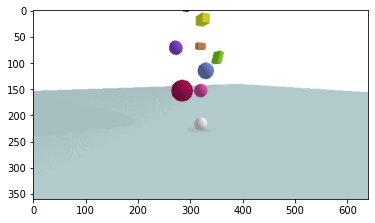

In [7]:
reset_simulation()
create_rigid_bodies()

_, _, img, _, _ = p.getCameraImage(pixelWidth, pixelHeight, viewMatrix,projectionMatrix, shadow=1, lightDirection=[1, 1, 1])
plt.imshow(img)
plt.show()

## 1.1 Implement explicit Euler integration for rigid bodies.

Update position, orientation, linear momentum and angular momentum of the rigid body if necessary. You may find [scipy.spatial.transform.Rotation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.html) helpful to transform between quaternions and rotation matrices. We will assume that **the only force is gravity.** The key reference is the page 689 of 06_RigidSim.pdf, which explains how to compute the derivative of the rigid body with quaternions. ** **write your code below (40 pts, 10 pts each)**  **

In [8]:
def quat_mult(q1, q2):
  """Quaternion multiplication. Note that q is defined as (x, y, z, w), which is differend from (w, x, y, z) in the slide"""
  v1, w1 = q1[:3], q1[3]
  v2, w2 = q2[:3], q2[3]
  q = np.zeros(4)
  q[:3] = w1 * v2 + w2 * v1 + np.cross(v1, v2)
  q[3] = w1 * w2 - v1 @ v2
  return q

def integrate_rigid_body(rb, dt):
  """
  Integrate a single rigid body by the timestep, dt.

  Args:
    rb: a Rigidbody object
    dt: integration time steps

  This function modifies rb. This function has no return value. If rb.fixed is true, then it should not move
  """
  # Student codes start here
  if rb.fixed:
    return
    
  # 1. update rb.position
  rb.position += rb.linear_momentum / rb.mass * dt

  # 2. update rb.orientation (06_RigidSim.pdf, page 68 and 69)
  # (hint: PyBullet defines quaternions as [x, y, z, w], which are different from [w, x, y, z] in the slide.)
  # (hint: use the quat_mult function)
  # (hint: Don't forget to normalize rb.orientation at the end. e.g., q = q / np.linalg.norm(q) )
  rOrient = R.from_quat(rb.orientation).as_matrix()
  inverseI = rOrient @ rb.inertia_inverse @ rOrient.T
  angV = inverseI @ rb.angular_momentum
  qDot = (1/2) * quat_mult(np.array([angV[0], angV[1], angV[2], 0.0]), rb.orientation)
  rb.orientation += qDot * dt
  rb.orientation = rb.orientation / np.linalg.norm(rb.orientation)
  
  # 3. update rb.linear momentum
  rb.linear_momentum += rb.mass * gravity * dt

  # 4. update rb.angular_momentum (hint: how gravity changes the angular momentum? The answer might be simple.)
  rb.angular_momentum += 0

  # Student codes end
  return


Here's a quick test code. We give the initial linear and angular mometum to the rigid body, and see if it moves as expected.

In [9]:
reset_simulation()
rb = Box(position=[0.3, -0.2, 4], half_extends=[0.2, 0.3, 0.2], mass=12, color=[0.937, 0.592, 0.384, 1])
rb.linear_momentum = np.array([1.0, 0.0, 0.0])
rb.angular_momentum = np.array([0.0, 0.0, 2.0])
for _ in range(2):
  integrate_rigid_body(rb, 0.01)
assert np.allclose(rb.position, np.array([0.30166667, -0.2, 3.999]), atol=1e-4)
assert np.allclose(rb.orientation, np.array([0., 0., 0.03844732, 0.999260]), atol=1e-4)
assert np.allclose(rb.linear_momentum, np.array([1., 0., -2.4]), atol=1e-4)
assert np.allclose(rb.angular_momentum, np.array([0., 0., 2.]), atol=1e-4)

## 1.2 Implement collision handling between two rigid bodies.

The next task is to implement the collision hander. Please refer to the slide 60 of 07_ConstrRigid.pdf. ** **write your code below (40 = 10 + 15 + 15 pts)**  **

In [11]:
def handle_collision(point, normal, A, B, e, debug=False):
  """
  Handles the collisions.

  Args:
    point: contact point
    normal: normal of B at contact point, pointing towards A 
    A: the first Rigidbody object
    B: The second Rigidbody object
    e: restitution parameter

  This function modifies A and B. This function has no return value
  If A.fixed or B.fixed is True, then this rigidbody is fixed and should not move
  """

  # prepare rA (displacement), vA (pre-impulse velocity), 1/mass, IA^(-1) (inverse of inertia in world coordinates)
  if A.fixed:
    rA = np.zeros(3)
    vA = np.zeros(3)
    invIA = np.zeros([3, 3])
    invmA = 0
  else:
    rA = point - A.position
    RA = R.from_quat(A.orientation).as_matrix()
    invIA = RA @ A.inertia_inverse @ RA.T
    wA = invIA @ A.angular_momentum
    vA = np.cross(wA, rA) + A.linear_momentum / A.mass
    invmA = 1. / A.mass
    
  # prepare rB, vB, IB^(-1)
  if B.fixed:
    rB = np.zeros(3)
    vB = np.zeros(3)
    invIB = np.zeros([3, 3])
    invmB = 0
  else:
    rB = point - B.position
    RB = R.from_quat(B.orientation).as_matrix()
    invIB = RB @ B.inertia_inverse @ RB.T
    wB = invIB @ B.angular_momentum
    vB = np.cross(wB, rB) + B.linear_momentum / B.mass
    invmB = 1. / B.mass

  # Student code starts here
  # 1. Check the relative velocity of points in the normal direction and skip a separating contact
  vr_pre = np.dot(normal, vA - vB)
  # write "if" statement here, and return if we do not need to handle this collision
  if vr_pre > 0:
    return

  # 2. Compute the impulse. How can we handle fixed objects?
  # (hint: use the predefined variables)
  top = -(1+e) * vr_pre  
  deltaA = np.cross((invIA @ np.cross(rA, normal)), rA) + normal * invmA
  deltaB = np.cross((invIB @ np.cross(rB, normal)), rB) + normal * invmB
  j = top / np.dot(normal, deltaA + deltaB)

  # 3. Update the linear and angular momentum of each object.
  # (hint: if A.fixed or B.fixed is true, you should not update its linear and angular momentum)
  # (hint: update both object A and B)
  # (hint: update both object.linear_momentum and object.angular_momentum)
  if not A.fixed:
    JA = np.dot(j, normal)
    TimpA = np.cross(rA, JA)

    A.linear_momentum += JA 
    A.angular_momentum += TimpA

  if not B.fixed:
    JB = np.dot(-j, normal)
    TimpB = np.cross(rB, JB)

    B.linear_momentum += JB
    B.angular_momentum += TimpB

  # Student code ends

  # Extra code for debugging
  if debug:
    wA_post = invIA @ A.angular_momentum
    vA_post = np.cross(wA_post, rA) + A.linear_momentum / A.mass
    wB_post = invIB @ B.angular_momentum
    vB_post = np.cross(wB_post, rB) + B.linear_momentum / B.mass
    vr_post = np.dot(normal, vA_post - vB_post)
    print('compare vr_pre(%.6f) and vr_post (%.6f)' % (vr_pre, vr_post))
    assert np.allclose(-1.0 * e * vr_pre, vr_post, atol=1e-4)
    print('pass the test!')
  return

Let do some quick tests.

In [12]:
reset_simulation()
A = Box(position=[-0.1, -0.05, 0], half_extends=[0.1, 0.1, 0.1], mass=12, color=[0.937, 0.592, 0.384, 1])
A.linear_momentum = np.array([10.0, 0.0, 0.0])
A.angular_momentum = np.array([0.0, 0.0, 0.0])
B = Box(position=[0.1, 0.05, 0], half_extends=[0.1, 0.1, 0.1], mass=12, color=[0.937, 0.592, 0.384, 1])
B.linear_momentum = np.array([-10.0, 0.0, 0.0])
B.angular_momentum = np.array([0.0, 0.0, 0.0])


handle_collision(point=np.zeros(3), normal=np.array((-1.0, 0.0, 0.0)), A=A, B=B, e=1.0,
                 debug=True)

reset_simulation()
A = Box(position=[-0.1, -0.05, 0], half_extends=[0.1, 0.1, 0.1], mass=12, color=[0.937, 0.592, 0.384, 1])
A.linear_momentum = np.array([10.0, 0.0, 0.0])
A.angular_momentum = np.array([0.0, 1.0, 1.0])
B = Box(position=[0.1, 0.05, 0], half_extends=[0.1, 0.1, 0.1], mass=12, color=[0.937, 0.592, 0.384, 1])
B.linear_momentum = np.array([-10.0, 0.0, 0.0])
B.angular_momentum = np.array([1.0, 0.0, -1.0])
handle_collision(point=np.zeros(3), normal=np.array((-1.0, 0.0, 0.0)), A=A, B=B, e=0.5,
                 debug=True)
              

compare vr_pre(-1.666667) and vr_post (1.666667)
pass the test!
compare vr_pre(-1.666667) and vr_post (0.833333)
pass the test!


## 1.3 Evaluation
Run the simulation and generate an animation.

In [13]:
reset_simulation()
create_rigid_bodies()

frame = 0
if not os.path.exists("./frames/"):
  os.makedirs("./frames/")

for i in range(480):
  # Integration
  for rb in RigidBody.rigid_body_list:
    integrate_rigid_body(rb, time_step)

  # Collision handling
  p.stepSimulation()
  contacts = p.getContactPoints()
  for contact in contacts:
    point = (np.array(contact[5]) + np.array(contact[6])) * 0.5
    normal = np.array(contact[7])
    A = RigidBody.uid_map[contact[1]]
    B = RigidBody.uid_map[contact[2]]
    handle_collision(point, normal, A, B, restitution)

  # Display in pybullet
  for rb in RigidBody.rigid_body_list:
    rb.update_pybullet()
    
  # Render frame
  if i % 10 == 0:
    _, _, img, _, _ = p.getCameraImage(pixelWidth, pixelHeight, viewMatrix,projectionMatrix, shadow=1, lightDirection=[1,1,1])
    Image.fromarray(img[:, :, :3]).save('./frames/frame%04d.jpg' % frame)
    frame += 1
    if frame % 10 == 0:
      print("Rendering frame #%d" % frame)
  time += time_step



Rendering frame #10
Rendering frame #20
Rendering frame #30
Rendering frame #40



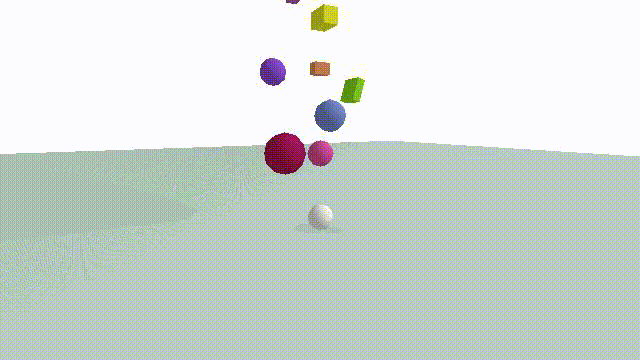

In [14]:
ffmpeg.input('./frames/frame*.jpg', pattern_type='glob', framerate=240.0/10).output('./output.gif').overwrite_output().run()
video = io.open('./output.gif', 'r+b').read()
encoded = base64.b64encode(video)
ipythondisplay.display(HTML(data='''<img src="data:image/gif;base64,{0}"/>'''.format(encoded.decode('ascii'))))

The generated animation only handles colliding contacts. Please summarize how would you handle resting contacts, based on Section Resting Contact in 07_ConstrRigid.pdf. Particularly, list the required conditions, describe the rough formulation of equations, and mention the type of solver. ** **write your answer below (20 pts)** **


There are three required conditions in handling resting contacts: non-penetration, repulsive force, and workless force. 

The first condition (non-penetration) is that the acceleration needs to be greater than or equal to 0. If the acceleration is negative, the bodies will accelerate towards each other, resulting in penetration. (di''(tc) >= 0, where di is the relative normal distance). The second condition (repulsive force) is that each contact force must be positive, meaning that each force must act outward in repulsive force, not in attraction. (fi >= 0) The third condition is that the force should be workless. If the contact is separating, then each contact force should not work and therefore equal to zero. If force is there, meaning the force is nonzero, the bodies should be held together. (fidi''(tc) = 0)

These contact forces can be formulated as a linear system such that it describes the relationship between each force and acceleration. This system can be built with a linear matrix with all its relevant factored terms, and it can be solved using quadratic programming. 



# 2. Extra points

2.1. Add a new type of object (e.g., capsule, cylinder, or mesh). You may want to investigate PyBullet APIs (e.g., createCollisionShape/VisualShape). Please refer to the document (https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit#). (hint: P0_introduction_to_notebook has an example simulation of R2D2.) ** **edit the above code directly and explain your implmenetation below (5 pts)**  **

(explain your implementation here)

2.2. Modify the create_rigid_bodies function to generate interesting animations. Name your animation. ** **edit the above code directly and write your answer below (2 pts)**  **

(explain your answer here)

2.3. Plot the energy (kinetic, potential, and their sum) of the system and discuss it. ** **edit the above code directly, write the plotting code below, and discuss your thoughts below (3 pts)**  **

In [ ]:
# Write your plotting code

(discuss your thoughts)

# 3. Research Project: Resting Contact.
So far, we only have implemented colliding contacts in this project. Can you implement a simulation with both resting and colliding contacts? For simplicity, you can assume the scenario, like a cube on a plane. You can extend this notebook, or write your new codes but you must implement collision handling by yourself. You can use the existing collision detection. Please refer to the lecture slides and the Baraff's tutorial (https://www.cs.cmu.edu/~baraff/sigcourse/notesd2.pdf) for technical details. 

Here is the list of the suggested steps:

1.   Write a single cube simulation where its initial position is "on" the plane. You can assume that you know the contact point locations
2.   Combine your sim with colliding contacts. This will allow you to drop a cube from a certain height.
3.   Extend the simulation for more generic cases. How can you know all the contacts?

**Deliverable:**
Please submit the code, the short document (e.g., how to run or how to use) and the demo video in a zip file. Please write down the downloadable link to the cell below.

**Points:**
10 additional points, but the sum of the extra question points and research project points will not exceed 10 points.